In [1]:
#!pip install tensorflow==2.12.0 tensorflow-addons==0.19.0



In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/Colab\ Downloads


all_reviews.csv  checkpoints  GMB_dataset.txt  Spam_SMS.csv


In [4]:
#!pip install pytorch-crf


In [11]:
import pandas as pd

# Define the file path (correct any spacing issues)
file_path = '/content/drive/MyDrive/Colab Downloads/all_reviews.csv'

# Load the CSV file into a DataFrame
all_reviews = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(all_reviews.head())


           userName                                            content  score  \
0     Kelly Catlady  Wacky riding stats recorded. Doesn't work for ...      1   
1       Paul Kamill  Useless app. There are supposedly videos, abou...      1   
2       Lee Merritt   very accurate, user friendly and doesn't glitch!      5   
3  William Reinhard           Nice simple app for tracking your rides.      5   
4   Albert Thompson  Installed this app after buying my bike a year...      5   

                  date     company  \
0  2024-11-08 04:43:27  Cannondale   
1  2024-11-03 16:02:04  Cannondale   
2  2024-10-15 17:59:59  Cannondale   
3  2024-10-03 16:28:29  Cannondale   
4  2024-09-26 08:31:47  Cannondale   

                                              tokens  \
0  ['wacky', 'riding', 'stats', 'recorded', 'was_...   
1  ['useless', 'app', 'there_are', 'supposedly', ...   
2  ['very', 'accurate', 'user_friendly', 'and', '...   
3  ['nice', 'simple', 'app', 'for', 'tracking', '...   
4  [

In [21]:
# Replace NaN or None with an empty string and ensure all values are strings
all_reviews['processed_text'] = all_reviews['processed_text'].fillna('').astype(str)


In [31]:
import os
from sklearn.metrics import classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split

# Step 1: Use the full dataset
all_reviews['processed_text'] = all_reviews['processed_text'].fillna('').astype(str)
X = all_reviews['processed_text'].tolist()
y = all_reviews['Topic'].tolist()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Define the Dataset class
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load tokenizer and create datasets
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset = ReviewDataset(X_train, y_train, tokenizer, max_length=32)
test_dataset = ReviewDataset(X_test, y_test, tokenizer, max_length=32)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)

# Step 3: Load the model
num_labels = len(all_reviews['Topic'].unique())
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

scaler = GradScaler()

# Early stopping and checkpointing
num_epochs = 10
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(epoch, model, optimizer, checkpoint_dir):
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pt")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

# Step 4: Training Loop with Early Stopping
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Use autocast
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")

    # Evaluate on test set
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(test_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}")

    # Save checkpoint if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        save_checkpoint(epoch+1, model, optimizer, checkpoint_dir)
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

# Step 5: Final Evaluation
print("Training complete. Best validation loss:", best_val_loss)

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=all_reviews['Topic'].unique().astype(str)))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-31-b21f78336c2f>:62: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-31-b21f78336c2f>:93

Epoch 1/10, Training Loss: 1.5725
Epoch 1/10, Validation Loss: 1.5507
Checkpoint saved: ./checkpoints/checkpoint_epoch_1.pt
Epoch 2/10, Training Loss: 1.3914
Epoch 2/10, Validation Loss: 1.4463
Checkpoint saved: ./checkpoints/checkpoint_epoch_2.pt
Epoch 3/10, Training Loss: 1.0170
Epoch 3/10, Validation Loss: 1.5676
No improvement for 1 epoch(s).
Epoch 4/10, Training Loss: 0.5212
Epoch 4/10, Validation Loss: 1.7605
No improvement for 2 epoch(s).
Epoch 5/10, Training Loss: 0.2121
Epoch 5/10, Validation Loss: 2.1661
No improvement for 3 epoch(s).
Early stopping triggered.
Training complete. Best validation loss: 1.44625513177169
Classification Report:
              precision    recall  f1-score   support

           1       0.41      0.59      0.49        85
           2       0.44      0.23      0.30        84
           0       0.42      0.40      0.41       105
           4       0.57      0.55      0.56        67
           3       0.45      0.50      0.48       113

    accuracy    

In [34]:
best_checkpoint_path = os.path.join(checkpoint_dir, "checkpoint_epoch_2.pt")


In [35]:
checkpoint = torch.load(best_checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)


<ipython-input-35-3a71cb7415f6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_checkpoint_path)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

<ipython-input-37-11c1a2182dff>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_checkpoint_path)


Test Accuracy: 0.3722


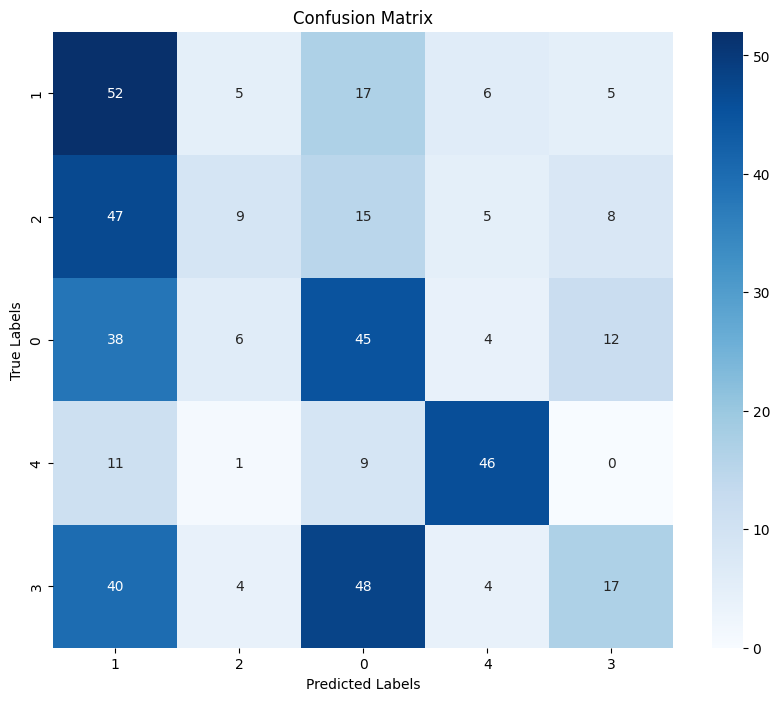

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reload the best checkpoint
best_checkpoint_path = os.path.join(checkpoint_dir, "checkpoint_epoch_2.pt")
checkpoint = torch.load(best_checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
labels = all_reviews['Topic'].unique().astype(str)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [33]:
import os

checkpoint_files = os.listdir(checkpoint_dir)
print("Available Checkpoints:", checkpoint_files)


Available Checkpoints: ['checkpoint_epoch_2.pt', 'checkpoint_epoch_1.pt']


In [38]:
# Step 1: Create a mapping from Topic to Category
topic_to_category = all_reviews[['Topic', 'Category']].drop_duplicates().set_index('Topic')['Category'].to_dict()

# Step 2: Map predictions and ground truth back to category names
all_preds_categories = [topic_to_category[topic] for topic in all_preds]
all_labels_categories = [topic_to_category[topic] for topic in all_labels]

# Step 3: Generate the classification report with category names
print("Classification Report by Category:")
print(classification_report(all_labels_categories, all_preds_categories, target_names=list(topic_to_category.values())))


Classification Report by Category:
                                       precision    recall  f1-score   support

Usability, Screen Features, and Speed       0.71      0.69      0.70        67
Data, Sensor, and Connectivity Issues       0.28      0.61      0.38        85
Battery, Mapping, and General Updates       0.34      0.43      0.38       105
   Features, Interface, and Usability       0.40      0.15      0.22       113
  Account Management and Login Issues       0.36      0.11      0.17        84

                             accuracy                           0.37       454
                            macro avg       0.42      0.40      0.37       454
                         weighted avg       0.40      0.37      0.35       454



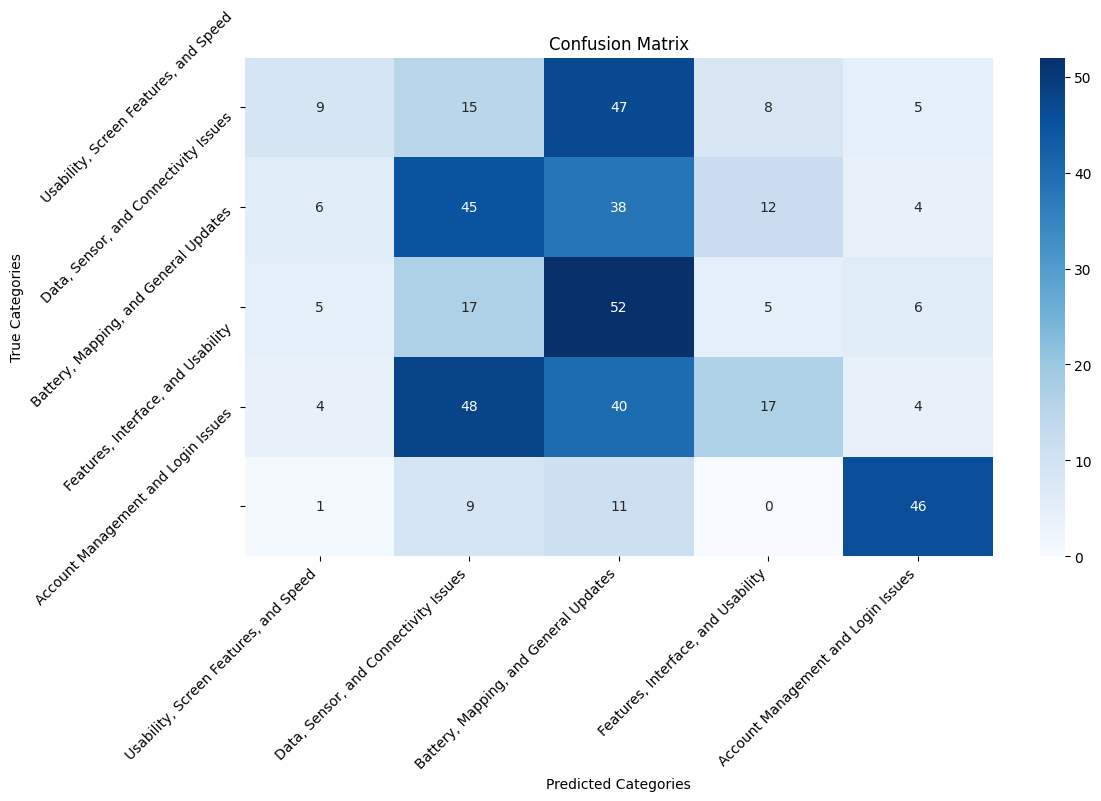

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Step 1: Create the confusion matrix
cm = confusion_matrix(all_labels_categories, all_preds_categories, labels=list(topic_to_category.values()))

# Step 2: Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(topic_to_category.values()), yticklabels=list(topic_to_category.values()))
plt.xlabel('Predicted Categories')
plt.ylabel('True Categories')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [44]:
from sklearn.metrics import classification_report
import pandas as pd

# Step 1: Generate the classification report as a dictionary
report = classification_report(all_labels_categories, all_preds_categories, target_names=list(topic_to_category.values()), output_dict=True)

# Step 2: Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Step 3: Filter out irrelevant rows (keep only categories)
category_scores = report_df.iloc[:-3][['precision', 'recall', 'f1-score']]

# Add category names for better readability
category_scores['Category'] = category_scores.index

# Reorder columns
category_scores = category_scores[['Category', 'precision', 'recall', 'f1-score']]

# Display the average scores by category
category_scores



,Category,precision,recall,f1-score
"Usability, Screen Features, and Speed","Usability, Screen Features, and Speed",0.707692,0.686567,0.696970
"Data, Sensor, and Connectivity Issues","Data, Sensor, and Connectivity Issues",0.276596,0.611765,0.380952
"Battery, Mapping, and General Updates","Battery, Mapping, and General Updates",0.335821,0.428571,0.376569
"Features, Interface, and Usability","Features, Interface, and Usability",0.404762,0.150442,0.219355
Account Management and Login Issues,Account Management and Login Issues,0.360000,0.107143,0.165138


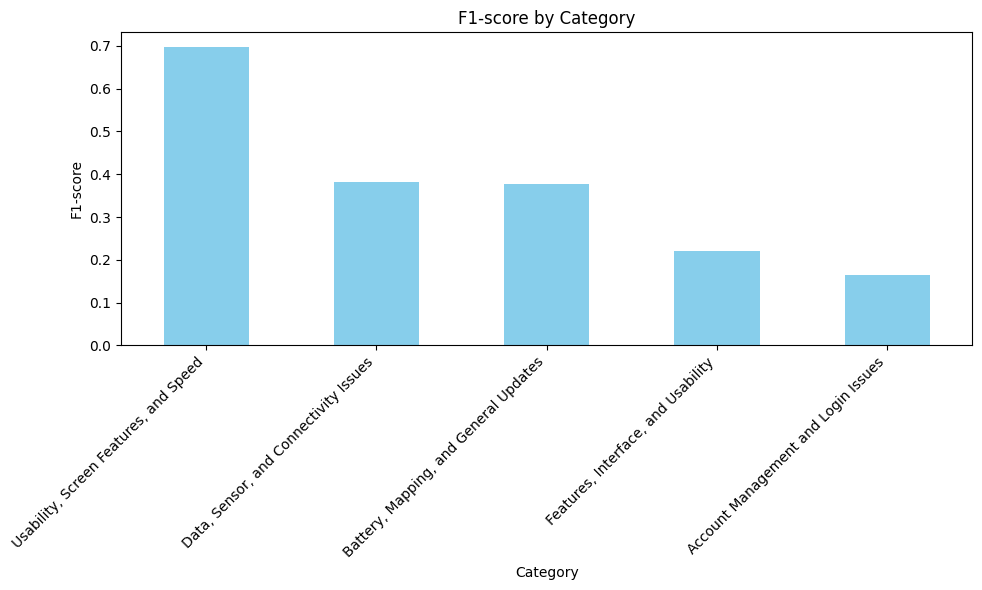

In [45]:
import matplotlib.pyplot as plt

# Plot F1-score by category
plt.figure(figsize=(10, 6))
category_scores.set_index('Category')['f1-score'].plot(kind='bar', color='skyblue')
plt.title('F1-score by Category')
plt.ylabel('F1-score')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [46]:
# Step 1: Ensure the 'score' column is numeric
all_reviews['score'] = pd.to_numeric(all_reviews['score'], errors='coerce')

# Step 2: Calculate the average score by category
average_scores = all_reviews.groupby('Category')['score'].mean().reset_index()

# Step 3: Rename columns for clarity
average_scores.columns = ['Category', 'Average Score']

# Display the results
average_scores

,Category,Average Score
0,Account Management and Login Issues,1.656766
1,"Battery, Mapping, and General Updates",2.343284
2,"Data, Sensor, and Connectivity Issues",2.298969
3,"Features, Interface, and Usability",2.273234
4,"Usability, Screen Features, and Speed",2.325397


                                 Category      company  Average Score
0     Account Management and Login Issues   Cannondale       1.373494
1     Account Management and Login Issues       Canyon       1.600000
2     Account Management and Login Issues        Giant       1.429688
3     Account Management and Login Issues  Specialized       2.327869
4     Account Management and Login Issues         Trek       2.238095
5   Battery, Mapping, and General Updates   Cannondale       2.269841
6   Battery, Mapping, and General Updates       Canyon       2.588235
7   Battery, Mapping, and General Updates        Giant       1.659420
8   Battery, Mapping, and General Updates  Specialized       2.782407
9   Battery, Mapping, and General Updates         Trek       2.342857
10  Data, Sensor, and Connectivity Issues   Cannondale       2.427586
11  Data, Sensor, and Connectivity Issues       Canyon       2.050000
12  Data, Sensor, and Connectivity Issues        Giant       1.900474
13  Data, Sensor, an

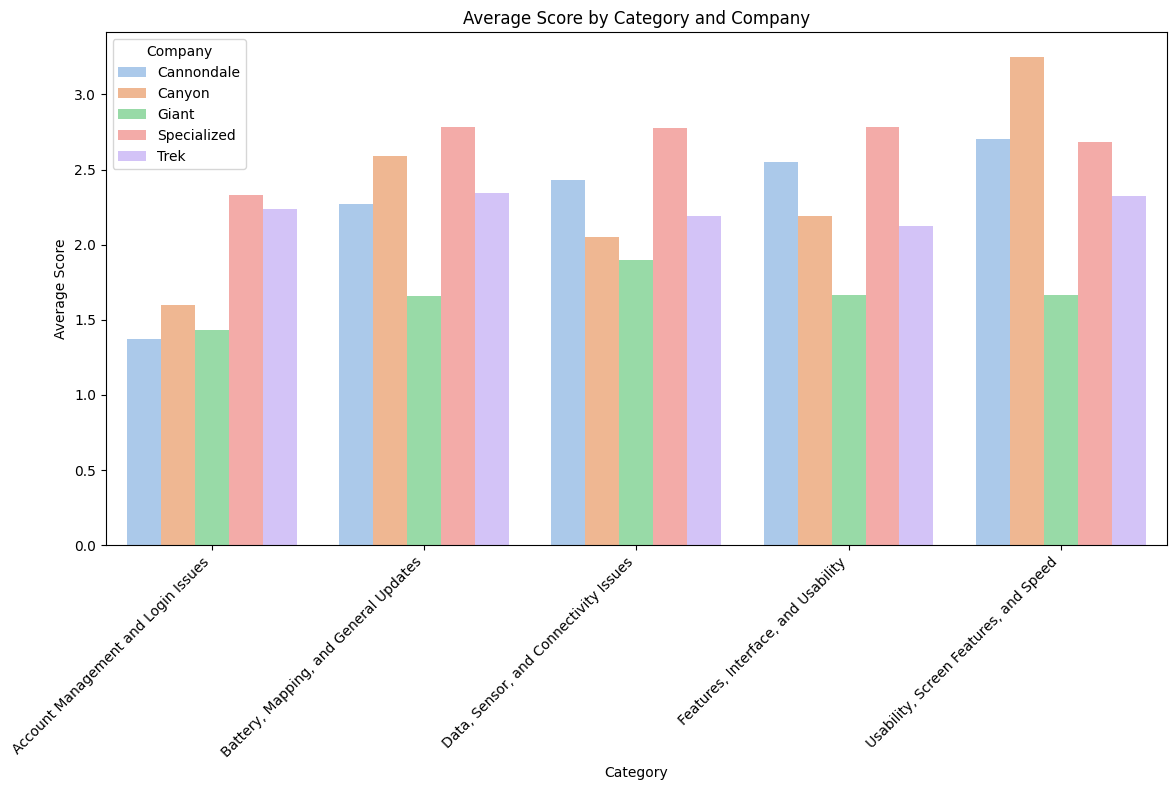

In [50]:
# Step 1: Ensure the 'score' column is numeric
all_reviews['score'] = pd.to_numeric(all_reviews['score'], errors='coerce')

# Step 2: Calculate the average score by category and company
average_scores_by_company = all_reviews.groupby(['Category', 'company'])['score'].mean().reset_index()

# Step 3: Rename columns for clarity
average_scores_by_company.columns = ['Category', 'company', 'Average Score']

# Display the results
print(average_scores_by_company)

# Optional: Save to CSV or visualize
# average_scores_by_company.to_csv('average_scores_by_category_and_company.csv', index=False)


import seaborn as sns
import matplotlib.pyplot as plt

# Create a grouped bar chart
plt.figure(figsize=(12, 8))
sns.barplot(
    data=average_scores_by_company,
    x='Category',
    y='Average Score',
    hue='company',
    palette='pastel'
)
plt.title('Average Score by Category and Company')
plt.ylabel('Average Score')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Company')
plt.tight_layout()
plt.show()
